In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 32)    128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 32)    128         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 32)    128         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 7.8141 - acc: 0.0821
Epoch 00001: val_loss improved from inf to 2.69709, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_3_conv_checkpoint/001-2.6971.hdf5
36805/36805 [==============================] - 36s 969us/sample - loss: 7.8139 - acc: 0.0821 - val_loss: 2.6971 - val_acc: 0.0934
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.0576 - acc: 0.0973
Epoch 00002: val_loss improved from 2.69709 to 2.52006, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_3_conv_checkpoint/002-2.5201.hdf5
36805/36805 [==============================] - 32s 871us/sample - loss: 5.0574 - acc: 0.0972 - val_loss: 2.5201 - val_acc: 0.2227
Epoch 3/500
36800/36805 [============================>.

Epoch 21/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6942 - acc: 0.4438
Epoch 00021: val_loss improved from 1.45287 to 1.38422, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_3_conv_checkpoint/021-1.3842.hdf5
36805/36805 [==============================] - 32s 871us/sample - loss: 1.6942 - acc: 0.4438 - val_loss: 1.3842 - val_acc: 0.6084
Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6623 - acc: 0.4532
Epoch 00022: val_loss improved from 1.38422 to 1.35226, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_3_conv_checkpoint/022-1.3523.hdf5
36805/36805 [==============================] - 32s 870us/sample - loss: 1.6623 - acc: 0.4531 - val_loss: 1.3523 - val_acc: 0.6108
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6435 - acc: 0.4641
Epoch 00023: val_loss improved from 1.35226 to 1.33837, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_

36800/36805 [============================>.] - ETA: 0s - loss: 1.3687 - acc: 0.5592
Epoch 00045: val_loss improved from 1.10807 to 1.08595, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_3_conv_checkpoint/045-1.0859.hdf5
36805/36805 [==============================] - 32s 866us/sample - loss: 1.3686 - acc: 0.5592 - val_loss: 1.0859 - val_acc: 0.6839
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3670 - acc: 0.5629
Epoch 00046: val_loss did not improve from 1.08595
36805/36805 [==============================] - 32s 866us/sample - loss: 1.3670 - acc: 0.5629 - val_loss: 1.0961 - val_acc: 0.6774
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3525 - acc: 0.5660
Epoch 00047: val_loss did not improve from 1.08595
36805/36805 [==============================] - 32s 862us/sample - loss: 1.3524 - acc: 0.5660 - val_loss: 1.1038 - val_acc: 0.6813
Epoch 48/500
36736/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 1.2604 - acc: 0.5944
Epoch 00072: val_loss improved from 0.97849 to 0.96008, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_3_conv_checkpoint/072-0.9601.hdf5
36805/36805 [==============================] - 31s 855us/sample - loss: 1.2605 - acc: 0.5944 - val_loss: 0.9601 - val_acc: 0.7223
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2629 - acc: 0.5933
Epoch 00073: val_loss did not improve from 0.96008
36805/36805 [==============================] - 32s 865us/sample - loss: 1.2630 - acc: 0.5933 - val_loss: 1.0693 - val_acc: 0.6716
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2597 - acc: 0.5950
Epoch 00074: val_loss did not improve from 0.96008
36805/36805 [==============================] - 32s 857us/sample - loss: 1.2597 - acc: 0.5950 - val_loss: 1.2103 - val_acc: 0.6047
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2020 - acc: 0.6112
Epoch 00100: val_loss did not improve from 0.90857
36805/36805 [==============================] - 32s 861us/sample - loss: 1.2020 - acc: 0.6112 - val_loss: 0.9384 - val_acc: 0.7221
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2034 - acc: 0.6122
Epoch 00101: val_loss did not improve from 0.90857
36805/36805 [==============================] - 32s 857us/sample - loss: 1.2034 - acc: 0.6121 - val_loss: 0.9797 - val_acc: 0.7009
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1965 - acc: 0.6161
Epoch 00102: val_loss did not improve from 0.90857
36805/36805 [==============================] - 32s 862us/sample - loss: 1.1966 - acc: 0.6161 - val_loss: 0.9949 - val_acc: 0.6995
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2026 - acc: 0.6149
Epoch 00103: val_loss did not improve from 0.90857
36805/36805 [=

Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1658 - acc: 0.6239
Epoch 00129: val_loss improved from 0.88609 to 0.87875, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_3_conv_checkpoint/129-0.8787.hdf5
36805/36805 [==============================] - 32s 858us/sample - loss: 1.1659 - acc: 0.6239 - val_loss: 0.8787 - val_acc: 0.7375
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1520 - acc: 0.6298
Epoch 00130: val_loss improved from 0.87875 to 0.85187, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_3_conv_checkpoint/130-0.8519.hdf5
36805/36805 [==============================] - 32s 869us/sample - loss: 1.1522 - acc: 0.6298 - val_loss: 0.8519 - val_acc: 0.7482
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1644 - acc: 0.6275
Epoch 00131: val_loss did not improve from 0.85187
36805/36805 [==============================] - 32s 856us/sample - loss: 1

Epoch 157/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1352 - acc: 0.6349
Epoch 00157: val_loss did not improve from 0.82977
36805/36805 [==============================] - 32s 859us/sample - loss: 1.1352 - acc: 0.6349 - val_loss: 0.9515 - val_acc: 0.7151
Epoch 158/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1303 - acc: 0.6380
Epoch 00158: val_loss did not improve from 0.82977
36805/36805 [==============================] - 32s 858us/sample - loss: 1.1301 - acc: 0.6381 - val_loss: 0.8933 - val_acc: 0.7200
Epoch 159/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1367 - acc: 0.6365
Epoch 00159: val_loss did not improve from 0.82977
36805/36805 [==============================] - 32s 861us/sample - loss: 1.1367 - acc: 0.6365 - val_loss: 0.9011 - val_acc: 0.7272
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1227 - acc: 0.6395
Epoch 00160: val_loss did not improve from 0.82977
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 1.1016 - acc: 0.6470
Epoch 00185: val_loss did not improve from 0.78809
36805/36805 [==============================] - 32s 864us/sample - loss: 1.1016 - acc: 0.6470 - val_loss: 0.8407 - val_acc: 0.7461
Epoch 186/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1028 - acc: 0.6427
Epoch 00186: val_loss did not improve from 0.78809
36805/36805 [==============================] - 31s 855us/sample - loss: 1.1030 - acc: 0.6427 - val_loss: 0.7929 - val_acc: 0.7624
Epoch 187/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1029 - acc: 0.6436
Epoch 00187: val_loss did not improve from 0.78809
36805/36805 [==============================] - 32s 863us/sample - loss: 1.1031 - acc: 0.6436 - val_loss: 0.8696 - val_acc: 0.7391
Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1015 - acc: 0.6452
Epoch 00188: val_loss did not improve from 0.78809
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 1.0883 - acc: 0.6495
Epoch 00214: val_loss did not improve from 0.77697
36805/36805 [==============================] - 31s 856us/sample - loss: 1.0884 - acc: 0.6495 - val_loss: 0.9435 - val_acc: 0.7095
Epoch 215/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0838 - acc: 0.6490
Epoch 00215: val_loss did not improve from 0.77697
36805/36805 [==============================] - 32s 861us/sample - loss: 1.0839 - acc: 0.6490 - val_loss: 0.9468 - val_acc: 0.7156
Epoch 216/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0835 - acc: 0.6507
Epoch 00216: val_loss did not improve from 0.77697
36805/36805 [==============================] - 31s 854us/sample - loss: 1.0835 - acc: 0.6507 - val_loss: 0.9818 - val_acc: 0.6881
Epoch 217/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0787 - acc: 0.6502
Epoch 00217: val_loss did not improve from 0.77697
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 1.0695 - acc: 0.6573
Epoch 00243: val_loss did not improve from 0.76202
36805/36805 [==============================] - 32s 865us/sample - loss: 1.0695 - acc: 0.6573 - val_loss: 0.9129 - val_acc: 0.7296
Epoch 244/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0615 - acc: 0.6589
Epoch 00244: val_loss did not improve from 0.76202
36805/36805 [==============================] - 32s 857us/sample - loss: 1.0616 - acc: 0.6589 - val_loss: 0.7978 - val_acc: 0.7596
Epoch 245/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0690 - acc: 0.6580
Epoch 00245: val_loss did not improve from 0.76202
36805/36805 [==============================] - 32s 863us/sample - loss: 1.0692 - acc: 0.6580 - val_loss: 0.8394 - val_acc: 0.7410
Epoch 246/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0641 - acc: 0.6579
Epoch 00246: val_loss did not improve from 0.76202
36805/36805 [===============

Epoch 273/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0540 - acc: 0.6608
Epoch 00273: val_loss did not improve from 0.76202
36805/36805 [==============================] - 32s 858us/sample - loss: 1.0539 - acc: 0.6608 - val_loss: 0.7985 - val_acc: 0.7738
Epoch 274/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0599 - acc: 0.6609
Epoch 00274: val_loss did not improve from 0.76202
36805/36805 [==============================] - 32s 861us/sample - loss: 1.0599 - acc: 0.6609 - val_loss: 0.8222 - val_acc: 0.7610
Epoch 275/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0517 - acc: 0.6633
Epoch 00275: val_loss did not improve from 0.76202
36805/36805 [==============================] - 32s 860us/sample - loss: 1.0516 - acc: 0.6633 - val_loss: 0.8304 - val_acc: 0.7615
Epoch 276/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0494 - acc: 0.6635
Epoch 00276: val_loss did not improve from 0.76202
36805/36805 [=

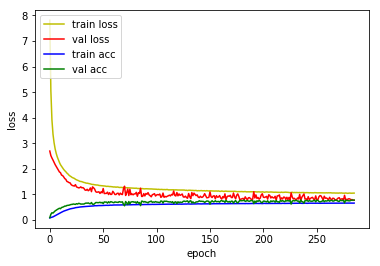

4815/4815 [==============================] - 2s 406us/sample - loss: 0.8079 - acc: 0.7624
Loss: 0.8079196328067086 Accuracy: 0.76240915

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 7.5879 - acc: 0.0830
Epoch 00001: val_loss improved from inf to 2.62787, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_4_conv_checkpoint/001-2.6279.hdf5
36805/36805 [==============================] - 36s 975us/sample - loss: 7.5878 - acc: 0.0830 - val_loss: 2.6279 - val_acc: 0.1407
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.7255 - acc: 0.0962
Epoch 00002: val_loss improved from 2.62787 to 2.50863, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_4_conv_checkpoint/002-2.5086.hdf5
36805/36805 [==============================] - 32s 870us/sample - loss: 4.7258 - acc: 0.0962 - val_loss: 2.5086 - val_acc: 0.1922
Epoch 3/500
36800/36805 [===================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4609 - acc: 0.5243
Epoch 00022: val_loss improved from 1.10973 to 1.09717, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_4_conv_checkpoint/022-1.0972.hdf5
36805/36805 [==============================] - 32s 874us/sample - loss: 1.4609 - acc: 0.5244 - val_loss: 1.0972 - val_acc: 0.6881
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4386 - acc: 0.5338
Epoch 00023: val_loss improved from 1.09717 to 1.05732, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_4_conv_checkpoint/023-1.0573.hdf5
36805/36805 [==============================] - 32s 863us/sample - loss: 1.4385 - acc: 0.5338 - val_loss: 1.0573 - val_acc: 0.7053
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4048 - acc: 0.5439
Epoch 00024: val_loss improved from 1.05732 to 1.04158, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_

Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1338 - acc: 0.6374
Epoch 00046: val_loss did not improve from 0.79626
36805/36805 [==============================] - 32s 872us/sample - loss: 1.1338 - acc: 0.6374 - val_loss: 0.8002 - val_acc: 0.7717
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1272 - acc: 0.6404
Epoch 00047: val_loss improved from 0.79626 to 0.79257, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_4_conv_checkpoint/047-0.7926.hdf5
36805/36805 [==============================] - 32s 871us/sample - loss: 1.1272 - acc: 0.6403 - val_loss: 0.7926 - val_acc: 0.7750
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1233 - acc: 0.6446
Epoch 00048: val_loss improved from 0.79257 to 0.77777, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_4_conv_checkpoint/048-0.7778.hdf5
36805/36805 [==============================] - 32s 869us/sample - loss: 1.12

Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9876 - acc: 0.6890
Epoch 00071: val_loss improved from 0.67075 to 0.65978, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_4_conv_checkpoint/071-0.6598.hdf5
36805/36805 [==============================] - 32s 872us/sample - loss: 0.9876 - acc: 0.6889 - val_loss: 0.6598 - val_acc: 0.8083
Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9970 - acc: 0.6848
Epoch 00072: val_loss did not improve from 0.65978
36805/36805 [==============================] - 32s 865us/sample - loss: 0.9971 - acc: 0.6848 - val_loss: 0.6911 - val_acc: 0.8069
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9899 - acc: 0.6864
Epoch 00073: val_loss did not improve from 0.65978
36805/36805 [==============================] - 32s 864us/sample - loss: 0.9900 - acc: 0.6865 - val_loss: 0.7420 - val_acc: 0.7843
Epoch 74/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.9271 - acc: 0.7091
Epoch 00098: val_loss did not improve from 0.61273
36805/36805 [==============================] - 32s 867us/sample - loss: 0.9271 - acc: 0.7091 - val_loss: 0.6396 - val_acc: 0.8134
Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9158 - acc: 0.7119
Epoch 00099: val_loss did not improve from 0.61273
36805/36805 [==============================] - 32s 861us/sample - loss: 0.9158 - acc: 0.7119 - val_loss: 0.6749 - val_acc: 0.8029
Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9114 - acc: 0.7103
Epoch 00100: val_loss did not improve from 0.61273
36805/36805 [==============================] - 32s 870us/sample - loss: 0.9113 - acc: 0.7103 - val_loss: 0.6664 - val_acc: 0.8118
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9161 - acc: 0.7128
Epoch 00101: val_loss improved from 0.61273 to 0.60632, saving model to model/ch

36800/36805 [============================>.] - ETA: 0s - loss: 0.8711 - acc: 0.7230
Epoch 00126: val_loss did not improve from 0.57526
36805/36805 [==============================] - 32s 867us/sample - loss: 0.8711 - acc: 0.7230 - val_loss: 0.5900 - val_acc: 0.8365
Epoch 127/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8666 - acc: 0.7270
Epoch 00127: val_loss did not improve from 0.57526
36805/36805 [==============================] - 32s 871us/sample - loss: 0.8665 - acc: 0.7270 - val_loss: 0.5964 - val_acc: 0.8321
Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8773 - acc: 0.7251
Epoch 00128: val_loss did not improve from 0.57526
36805/36805 [==============================] - 32s 861us/sample - loss: 0.8776 - acc: 0.7250 - val_loss: 0.6016 - val_acc: 0.8297
Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8715 - acc: 0.7253
Epoch 00129: val_loss did not improve from 0.57526
36805/36805 [===============

Epoch 155/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8377 - acc: 0.7360
Epoch 00155: val_loss did not improve from 0.54223
36805/36805 [==============================] - 32s 861us/sample - loss: 0.8377 - acc: 0.7360 - val_loss: 0.5759 - val_acc: 0.8348
Epoch 156/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8414 - acc: 0.7368
Epoch 00156: val_loss did not improve from 0.54223
36805/36805 [==============================] - 32s 864us/sample - loss: 0.8415 - acc: 0.7368 - val_loss: 0.6104 - val_acc: 0.8197
Epoch 157/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8341 - acc: 0.7388
Epoch 00157: val_loss did not improve from 0.54223
36805/36805 [==============================] - 32s 870us/sample - loss: 0.8340 - acc: 0.7388 - val_loss: 0.5508 - val_acc: 0.8388
Epoch 158/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8344 - acc: 0.7358
Epoch 00158: val_loss did not improve from 0.54223
36805/36805 [=

Epoch 184/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8184 - acc: 0.7430
Epoch 00184: val_loss did not improve from 0.52655
36805/36805 [==============================] - 32s 869us/sample - loss: 0.8184 - acc: 0.7431 - val_loss: 0.5391 - val_acc: 0.8491
Epoch 185/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8026 - acc: 0.7503
Epoch 00185: val_loss did not improve from 0.52655
36805/36805 [==============================] - 32s 869us/sample - loss: 0.8027 - acc: 0.7503 - val_loss: 0.5472 - val_acc: 0.8444
Epoch 186/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8098 - acc: 0.7454
Epoch 00186: val_loss did not improve from 0.52655
36805/36805 [==============================] - 32s 869us/sample - loss: 0.8099 - acc: 0.7454 - val_loss: 0.5455 - val_acc: 0.8456
Epoch 187/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8122 - acc: 0.7423
Epoch 00187: val_loss did not improve from 0.52655
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.7936 - acc: 0.7491
Epoch 00212: val_loss did not improve from 0.51794
36805/36805 [==============================] - 32s 867us/sample - loss: 0.7937 - acc: 0.7491 - val_loss: 0.5353 - val_acc: 0.8495
Epoch 213/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7876 - acc: 0.7508
Epoch 00213: val_loss did not improve from 0.51794
36805/36805 [==============================] - 32s 864us/sample - loss: 0.7877 - acc: 0.7508 - val_loss: 0.5265 - val_acc: 0.8509
Epoch 214/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7925 - acc: 0.7502
Epoch 00214: val_loss did not improve from 0.51794
36805/36805 [==============================] - 32s 868us/sample - loss: 0.7924 - acc: 0.7503 - val_loss: 0.5463 - val_acc: 0.8414
Epoch 215/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7857 - acc: 0.7538
Epoch 00215: val_loss did not improve from 0.51794
36805/36805 [===============

Epoch 242/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7728 - acc: 0.7568
Epoch 00242: val_loss did not improve from 0.51794
36805/36805 [==============================] - 32s 869us/sample - loss: 0.7730 - acc: 0.7567 - val_loss: 0.5199 - val_acc: 0.8516
Epoch 243/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7766 - acc: 0.7517
Epoch 00243: val_loss did not improve from 0.51794
36805/36805 [==============================] - 32s 869us/sample - loss: 0.7765 - acc: 0.7518 - val_loss: 0.5677 - val_acc: 0.8332
Epoch 244/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7667 - acc: 0.7598
Epoch 00244: val_loss did not improve from 0.51794
36805/36805 [==============================] - 32s 868us/sample - loss: 0.7668 - acc: 0.7598 - val_loss: 0.5332 - val_acc: 0.8444
Epoch 245/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7684 - acc: 0.7578
Epoch 00245: val_loss did not improve from 0.51794
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.7577 - acc: 0.7618
Epoch 00270: val_loss did not improve from 0.49622
36805/36805 [==============================] - 32s 865us/sample - loss: 0.7576 - acc: 0.7618 - val_loss: 0.5193 - val_acc: 0.8474
Epoch 271/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7576 - acc: 0.7609
Epoch 00271: val_loss did not improve from 0.49622
36805/36805 [==============================] - 32s 865us/sample - loss: 0.7575 - acc: 0.7610 - val_loss: 0.5464 - val_acc: 0.8395
Epoch 272/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7528 - acc: 0.7625
Epoch 00272: val_loss did not improve from 0.49622
36805/36805 [==============================] - 32s 864us/sample - loss: 0.7529 - acc: 0.7625 - val_loss: 0.5402 - val_acc: 0.8481
Epoch 273/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7542 - acc: 0.7604
Epoch 00273: val_loss did not improve from 0.49622
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.7453 - acc: 0.7644
Epoch 00299: val_loss did not improve from 0.49432
36805/36805 [==============================] - 32s 866us/sample - loss: 0.7454 - acc: 0.7643 - val_loss: 0.5167 - val_acc: 0.8514
Epoch 300/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7395 - acc: 0.7659
Epoch 00300: val_loss did not improve from 0.49432
36805/36805 [==============================] - 32s 868us/sample - loss: 0.7395 - acc: 0.7659 - val_loss: 0.5026 - val_acc: 0.8528
Epoch 301/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7390 - acc: 0.7683
Epoch 00301: val_loss did not improve from 0.49432
36805/36805 [==============================] - 32s 871us/sample - loss: 0.7391 - acc: 0.7682 - val_loss: 0.5326 - val_acc: 0.8477
Epoch 302/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7399 - acc: 0.7665
Epoch 00302: val_loss did not improve from 0.49432
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.7293 - acc: 0.7687
Epoch 00328: val_loss did not improve from 0.49400
36805/36805 [==============================] - 32s 866us/sample - loss: 0.7294 - acc: 0.7687 - val_loss: 0.5362 - val_acc: 0.8463
Epoch 329/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7335 - acc: 0.7694
Epoch 00329: val_loss did not improve from 0.49400
36805/36805 [==============================] - 32s 868us/sample - loss: 0.7334 - acc: 0.7694 - val_loss: 0.5525 - val_acc: 0.8353
Epoch 330/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7266 - acc: 0.7722
Epoch 00330: val_loss did not improve from 0.49400
36805/36805 [==============================] - 32s 873us/sample - loss: 0.7267 - acc: 0.7722 - val_loss: 0.5116 - val_acc: 0.8488
Epoch 331/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7243 - acc: 0.7728
Epoch 00331: val_loss did not improve from 0.49400
36805/36805 [===============

Epoch 358/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7270 - acc: 0.7689
Epoch 00358: val_loss did not improve from 0.49400
36805/36805 [==============================] - 32s 875us/sample - loss: 0.7269 - acc: 0.7689 - val_loss: 0.5221 - val_acc: 0.8512
Epoch 359/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7110 - acc: 0.7744
Epoch 00359: val_loss did not improve from 0.49400
36805/36805 [==============================] - 32s 866us/sample - loss: 0.7111 - acc: 0.7744 - val_loss: 0.5140 - val_acc: 0.8505
Epoch 360/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7071 - acc: 0.7741
Epoch 00360: val_loss did not improve from 0.49400
36805/36805 [==============================] - 32s 870us/sample - loss: 0.7071 - acc: 0.7741 - val_loss: 0.5374 - val_acc: 0.8421
Epoch 361/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7180 - acc: 0.7742
Epoch 00361: val_loss did not improve from 0.49400
36805/36805 [=

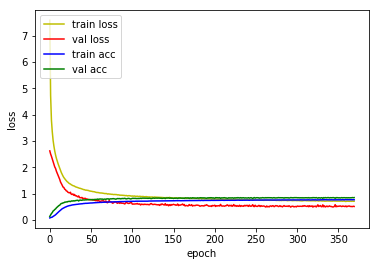

4815/4815 [==============================] - 2s 445us/sample - loss: 0.5595 - acc: 0.8345
Loss: 0.5594838753667576 Accuracy: 0.8344756

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.1680 - acc: 0.0817
Epoch 00001: val_loss improved from inf to 2.60049, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_5_conv_checkpoint/001-2.6005.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 6.1678 - acc: 0.0816 - val_loss: 2.6005 - val_acc: 0.1740
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 3.8128 - acc: 0.1100
Epoch 00002: val_loss improved from 2.60049 to 2.24539, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_5_conv_checkpoint/002-2.2454.hdf5
36805/36805 [==============================] - 34s 910us/sample - loss: 3.8119 - acc: 0.1100 - val_loss: 2.2454 - val_acc: 0.3103
Epoch 3/500
36800/36805 [======================

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9092 - acc: 0.7126
Epoch 00022: val_loss improved from 0.63377 to 0.57471, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_5_conv_checkpoint/022-0.5747.hdf5
36805/36805 [==============================] - 33s 908us/sample - loss: 0.9092 - acc: 0.7126 - val_loss: 0.5747 - val_acc: 0.8325
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8892 - acc: 0.7209
Epoch 00023: val_loss improved from 0.57471 to 0.56748, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_5_conv_checkpoint/023-0.5675.hdf5
36805/36805 [==============================] - 33s 909us/sample - loss: 0.8892 - acc: 0.7209 - val_loss: 0.5675 - val_acc: 0.8358
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8693 - acc: 0.7278
Epoch 00024: val_loss improved from 0.56748 to 0.55779, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_

Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6306 - acc: 0.8082
Epoch 00046: val_loss improved from 0.41371 to 0.40625, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_5_conv_checkpoint/046-0.4062.hdf5
36805/36805 [==============================] - 34s 912us/sample - loss: 0.6306 - acc: 0.8081 - val_loss: 0.4062 - val_acc: 0.8861
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6088 - acc: 0.8124
Epoch 00047: val_loss improved from 0.40625 to 0.39722, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_5_conv_checkpoint/047-0.3972.hdf5
36805/36805 [==============================] - 34s 913us/sample - loss: 0.6088 - acc: 0.8124 - val_loss: 0.3972 - val_acc: 0.8945
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6139 - acc: 0.8103
Epoch 00048: val_loss did not improve from 0.39722
36805/36805 [==============================] - 34s 916us/sample - loss: 0.61

36800/36805 [============================>.] - ETA: 0s - loss: 0.5131 - acc: 0.8429
Epoch 00072: val_loss did not improve from 0.33189
36805/36805 [==============================] - 33s 909us/sample - loss: 0.5130 - acc: 0.8429 - val_loss: 0.3621 - val_acc: 0.8961
Epoch 73/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5135 - acc: 0.8429
Epoch 00073: val_loss improved from 0.33189 to 0.33184, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_5_conv_checkpoint/073-0.3318.hdf5
36805/36805 [==============================] - 33s 909us/sample - loss: 0.5134 - acc: 0.8428 - val_loss: 0.3318 - val_acc: 0.9040
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5016 - acc: 0.8467
Epoch 00074: val_loss did not improve from 0.33184
36805/36805 [==============================] - 34s 911us/sample - loss: 0.5016 - acc: 0.8467 - val_loss: 0.3379 - val_acc: 0.9024
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4541 - acc: 0.8603
Epoch 00099: val_loss did not improve from 0.30204
36805/36805 [==============================] - 34s 911us/sample - loss: 0.4542 - acc: 0.8603 - val_loss: 0.3113 - val_acc: 0.9087
Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4518 - acc: 0.8620
Epoch 00100: val_loss did not improve from 0.30204
36805/36805 [==============================] - 34s 914us/sample - loss: 0.4517 - acc: 0.8620 - val_loss: 0.3038 - val_acc: 0.9138
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4532 - acc: 0.8604
Epoch 00101: val_loss did not improve from 0.30204
36805/36805 [==============================] - 34s 911us/sample - loss: 0.4531 - acc: 0.8605 - val_loss: 0.3693 - val_acc: 0.8910
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4514 - acc: 0.8635
Epoch 00102: val_loss did not improve from 0.30204
36805/36805 [==

Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4099 - acc: 0.8724
Epoch 00128: val_loss did not improve from 0.28953
36805/36805 [==============================] - 34s 911us/sample - loss: 0.4098 - acc: 0.8724 - val_loss: 0.3008 - val_acc: 0.9085
Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4062 - acc: 0.8755
Epoch 00129: val_loss did not improve from 0.28953
36805/36805 [==============================] - 34s 916us/sample - loss: 0.4062 - acc: 0.8755 - val_loss: 0.3039 - val_acc: 0.9124
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4033 - acc: 0.8744
Epoch 00130: val_loss did not improve from 0.28953
36805/36805 [==============================] - 33s 908us/sample - loss: 0.4034 - acc: 0.8744 - val_loss: 0.2924 - val_acc: 0.9147
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4111 - acc: 0.8727
Epoch 00131: val_loss improved from 0.28953 to 0.28900, saving mo

Epoch 156/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3883 - acc: 0.8818
Epoch 00156: val_loss did not improve from 0.27675
36805/36805 [==============================] - 34s 914us/sample - loss: 0.3883 - acc: 0.8818 - val_loss: 0.2814 - val_acc: 0.9220
Epoch 157/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3817 - acc: 0.8808
Epoch 00157: val_loss did not improve from 0.27675
36805/36805 [==============================] - 34s 912us/sample - loss: 0.3818 - acc: 0.8807 - val_loss: 0.2875 - val_acc: 0.9189
Epoch 158/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3821 - acc: 0.8812
Epoch 00158: val_loss did not improve from 0.27675
36805/36805 [==============================] - 34s 913us/sample - loss: 0.3821 - acc: 0.8812 - val_loss: 0.2837 - val_acc: 0.9220
Epoch 159/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3786 - acc: 0.8821
Epoch 00159: val_loss did not improve from 0.27675
36805/36805 [=

Epoch 185/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3570 - acc: 0.8903
Epoch 00185: val_loss did not improve from 0.27279
36805/36805 [==============================] - 33s 907us/sample - loss: 0.3570 - acc: 0.8903 - val_loss: 0.2803 - val_acc: 0.9201
Epoch 186/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3603 - acc: 0.8881
Epoch 00186: val_loss did not improve from 0.27279
36805/36805 [==============================] - 34s 911us/sample - loss: 0.3604 - acc: 0.8881 - val_loss: 0.3141 - val_acc: 0.9117
Epoch 187/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3580 - acc: 0.8882
Epoch 00187: val_loss did not improve from 0.27279
36805/36805 [==============================] - 33s 909us/sample - loss: 0.3581 - acc: 0.8881 - val_loss: 0.3210 - val_acc: 0.9057
Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3501 - acc: 0.8906
Epoch 00188: val_loss did not improve from 0.27279
36805/36805 [=

Epoch 214/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3381 - acc: 0.8934
Epoch 00214: val_loss did not improve from 0.26763
36805/36805 [==============================] - 34s 915us/sample - loss: 0.3381 - acc: 0.8934 - val_loss: 0.2804 - val_acc: 0.9206
Epoch 215/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3418 - acc: 0.8932
Epoch 00215: val_loss did not improve from 0.26763
36805/36805 [==============================] - 33s 908us/sample - loss: 0.3418 - acc: 0.8932 - val_loss: 0.3025 - val_acc: 0.9147
Epoch 216/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3378 - acc: 0.8941
Epoch 00216: val_loss did not improve from 0.26763
36805/36805 [==============================] - 34s 915us/sample - loss: 0.3378 - acc: 0.8941 - val_loss: 0.2776 - val_acc: 0.9187
Epoch 217/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3333 - acc: 0.8962
Epoch 00217: val_loss did not improve from 0.26763
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.3251 - acc: 0.8980- 
Epoch 00243: val_loss did not improve from 0.26763
36805/36805 [==============================] - 33s 905us/sample - loss: 0.3251 - acc: 0.8979 - val_loss: 0.3069 - val_acc: 0.9136
Epoch 244/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3195 - acc: 0.8991
Epoch 00244: val_loss did not improve from 0.26763
36805/36805 [==============================] - 34s 913us/sample - loss: 0.3195 - acc: 0.8991 - val_loss: 0.3062 - val_acc: 0.9108
Epoch 245/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3247 - acc: 0.8977
Epoch 00245: val_loss did not improve from 0.26763
36805/36805 [==============================] - 34s 910us/sample - loss: 0.3247 - acc: 0.8977 - val_loss: 0.2851 - val_acc: 0.9194
Epoch 246/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3194 - acc: 0.8984
Epoch 00246: val_loss did not improve from 0.26763
36805/36805 [=============

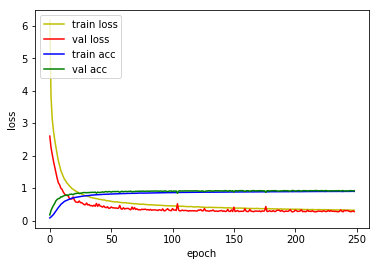

4815/4815 [==============================] - 2s 458us/sample - loss: 0.3062 - acc: 0.9105
Loss: 0.30616259550132235 Accuracy: 0.91048807

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.4039 - acc: 0.1259
Epoch 00001: val_loss improved from inf to 2.06940, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_6_conv_checkpoint/001-2.0694.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 5.4039 - acc: 0.1259 - val_loss: 2.0694 - val_acc: 0.3436
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.3543 - acc: 0.2073
Epoch 00002: val_loss improved from 2.06940 to 1.53459, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_6_conv_checkpoint/002-1.5346.hdf5
36805/36805 [==============================] - 35s 945us/sample - loss: 3.3544 - acc: 0.2073 - val_loss: 1.5346 - val_acc: 0.5458
Epoch 3/500
36800/36805 [====================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5093 - acc: 0.8433
Epoch 00023: val_loss improved from 0.28787 to 0.27596, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_6_conv_checkpoint/023-0.2760.hdf5
36805/36805 [==============================] - 35s 947us/sample - loss: 0.5093 - acc: 0.8433 - val_loss: 0.2760 - val_acc: 0.9273
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4921 - acc: 0.8499
Epoch 00024: val_loss did not improve from 0.27596
36805/36805 [==============================] - 35s 941us/sample - loss: 0.4921 - acc: 0.8499 - val_loss: 0.2826 - val_acc: 0.9203
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4842 - acc: 0.8515
Epoch 00025: val_loss did not improve from 0.27596
36805/36805 [==============================] - 35s 941us/sample - loss: 0.4841 - acc: 0.8516 - val_loss: 0.2802 - val_acc: 0.9192
Epoch 26/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.3227 - acc: 0.9010
Epoch 00049: val_loss did not improve from 0.20686
36805/36805 [==============================] - 35s 940us/sample - loss: 0.3227 - acc: 0.9010 - val_loss: 0.2329 - val_acc: 0.9329
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3242 - acc: 0.9006
Epoch 00050: val_loss improved from 0.20686 to 0.19988, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_6_conv_checkpoint/050-0.1999.hdf5
36805/36805 [==============================] - 35s 943us/sample - loss: 0.3241 - acc: 0.9006 - val_loss: 0.1999 - val_acc: 0.9443
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3201 - acc: 0.9025
Epoch 00051: val_loss did not improve from 0.19988
36805/36805 [==============================] - 34s 937us/sample - loss: 0.3200 - acc: 0.9025 - val_loss: 0.2091 - val_acc: 0.9378
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2549 - acc: 0.9205
Epoch 00076: val_loss did not improve from 0.17097
36805/36805 [==============================] - 34s 936us/sample - loss: 0.2549 - acc: 0.9205 - val_loss: 0.1777 - val_acc: 0.9506
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2485 - acc: 0.9210
Epoch 00077: val_loss did not improve from 0.17097
36805/36805 [==============================] - 34s 934us/sample - loss: 0.2485 - acc: 0.9210 - val_loss: 0.1969 - val_acc: 0.9397
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2498 - acc: 0.9219
Epoch 00078: val_loss did not improve from 0.17097
36805/36805 [==============================] - 34s 936us/sample - loss: 0.2499 - acc: 0.9219 - val_loss: 0.1770 - val_acc: 0.9499
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2498 - acc: 0.9220
Epoch 00079: val_loss did not improve from 0.17097
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.2089 - acc: 0.9344
Epoch 00104: val_loss did not improve from 0.15716
36805/36805 [==============================] - 35s 939us/sample - loss: 0.2090 - acc: 0.9344 - val_loss: 0.1614 - val_acc: 0.9515
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2134 - acc: 0.9331
Epoch 00105: val_loss did not improve from 0.15716
36805/36805 [==============================] - 35s 939us/sample - loss: 0.2133 - acc: 0.9331 - val_loss: 0.1755 - val_acc: 0.9457
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2069 - acc: 0.9349
Epoch 00106: val_loss improved from 0.15716 to 0.15665, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_6_conv_checkpoint/106-0.1567.hdf5
36805/36805 [==============================] - 35s 941us/sample - loss: 0.2070 - acc: 0.9349 - val_loss: 0.1567 - val_acc: 0.9527
Epoch 107/500
36800/36805 [============================>.] - ETA: 0

Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1828 - acc: 0.9420
Epoch 00133: val_loss did not improve from 0.15190
36805/36805 [==============================] - 34s 934us/sample - loss: 0.1828 - acc: 0.9420 - val_loss: 0.1592 - val_acc: 0.9525
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1807 - acc: 0.9412
Epoch 00134: val_loss did not improve from 0.15190
36805/36805 [==============================] - 35s 939us/sample - loss: 0.1806 - acc: 0.9412 - val_loss: 0.1674 - val_acc: 0.9499
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1769 - acc: 0.9439
Epoch 00135: val_loss did not improve from 0.15190
36805/36805 [==============================] - 34s 937us/sample - loss: 0.1769 - acc: 0.9439 - val_loss: 0.1677 - val_acc: 0.9488
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1766 - acc: 0.9432
Epoch 00136: val_loss did not improve from 0.15190
36805/36805 [=

Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1575 - acc: 0.9508
Epoch 00162: val_loss did not improve from 0.15069
36805/36805 [==============================] - 35s 941us/sample - loss: 0.1575 - acc: 0.9508 - val_loss: 0.1617 - val_acc: 0.9520
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1585 - acc: 0.9497
Epoch 00163: val_loss did not improve from 0.15069
36805/36805 [==============================] - 35s 938us/sample - loss: 0.1585 - acc: 0.9497 - val_loss: 0.1586 - val_acc: 0.9504
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1559 - acc: 0.9490
Epoch 00164: val_loss did not improve from 0.15069
36805/36805 [==============================] - 35s 942us/sample - loss: 0.1560 - acc: 0.9489 - val_loss: 0.1563 - val_acc: 0.9502
Epoch 165/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1598 - acc: 0.9479
Epoch 00165: val_loss did not improve from 0.15069
36805/36805 [=

Epoch 191/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1386 - acc: 0.9554
Epoch 00191: val_loss improved from 0.14898 to 0.14728, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_6_conv_checkpoint/191-0.1473.hdf5
36805/36805 [==============================] - 35s 942us/sample - loss: 0.1386 - acc: 0.9554 - val_loss: 0.1473 - val_acc: 0.9541
Epoch 192/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1424 - acc: 0.9542
Epoch 00192: val_loss did not improve from 0.14728
36805/36805 [==============================] - 35s 963us/sample - loss: 0.1424 - acc: 0.9542 - val_loss: 0.2064 - val_acc: 0.9401
Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1400 - acc: 0.9561
Epoch 00193: val_loss did not improve from 0.14728
36805/36805 [==============================] - 35s 939us/sample - loss: 0.1400 - acc: 0.9561 - val_loss: 0.1662 - val_acc: 0.9520
Epoch 194/500
36800/36805 [==========================

Epoch 220/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1275 - acc: 0.9583
Epoch 00220: val_loss did not improve from 0.14728
36805/36805 [==============================] - 35s 939us/sample - loss: 0.1275 - acc: 0.9583 - val_loss: 0.1633 - val_acc: 0.9550
Epoch 221/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1281 - acc: 0.9590
Epoch 00221: val_loss did not improve from 0.14728
36805/36805 [==============================] - 34s 936us/sample - loss: 0.1281 - acc: 0.9590 - val_loss: 0.1670 - val_acc: 0.9511
Epoch 222/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1225 - acc: 0.9605
Epoch 00222: val_loss did not improve from 0.14728
36805/36805 [==============================] - 34s 936us/sample - loss: 0.1225 - acc: 0.9605 - val_loss: 0.1900 - val_acc: 0.9457
Epoch 223/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1276 - acc: 0.9583
Epoch 00223: val_loss did not improve from 0.14728
36805/36805 [=

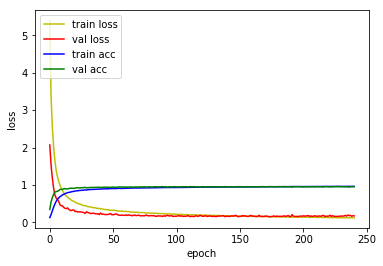

4815/4815 [==============================] - 2s 500us/sample - loss: 0.1908 - acc: 0.9396
Loss: 0.1907717812779289 Accuracy: 0.9395639

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.2396 - acc: 0.1586
Epoch 00001: val_loss improved from inf to 1.75982, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_7_conv_checkpoint/001-1.7598.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 4.2395 - acc: 0.1586 - val_loss: 1.7598 - val_acc: 0.5083
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4566 - acc: 0.3432
Epoch 00002: val_loss improved from 1.75982 to 0.91609, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_7_conv_checkpoint/002-0.9161.hdf5
36805/36805 [==============================] - 36s 970us/sample - loss: 2.4565 - acc: 0.3432 - val_loss: 0.9161 - val_acc: 0.7247
Epoch 3/500
36800/36805 [======================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2995 - acc: 0.9071
Epoch 00024: val_loss did not improve from 0.17246
36805/36805 [==============================] - 35s 962us/sample - loss: 0.2995 - acc: 0.9072 - val_loss: 0.1756 - val_acc: 0.9488
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2899 - acc: 0.9081
Epoch 00025: val_loss improved from 0.17246 to 0.16888, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_7_conv_checkpoint/025-0.1689.hdf5
36805/36805 [==============================] - 36s 968us/sample - loss: 0.2898 - acc: 0.9081 - val_loss: 0.1689 - val_acc: 0.9522
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2755 - acc: 0.9156
Epoch 00026: val_loss did not improve from 0.16888
36805/36805 [==============================] - 35s 959us/sample - loss: 0.2755 - acc: 0.9156 - val_loss: 0.1724 - val_acc: 0.9495
Epoch 27/500
36800/36805 [============================>.

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1685 - acc: 0.9471
Epoch 00050: val_loss did not improve from 0.12553
36805/36805 [==============================] - 35s 963us/sample - loss: 0.1685 - acc: 0.9471 - val_loss: 0.1374 - val_acc: 0.9585
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1646 - acc: 0.9488
Epoch 00051: val_loss did not improve from 0.12553
36805/36805 [==============================] - 35s 963us/sample - loss: 0.1648 - acc: 0.9487 - val_loss: 0.1355 - val_acc: 0.9585
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1637 - acc: 0.9478
Epoch 00052: val_loss did not improve from 0.12553
36805/36805 [==============================] - 36s 965us/sample - loss: 0.1638 - acc: 0.9478 - val_loss: 0.1605 - val_acc: 0.9529
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1586 - acc: 0.9506
Epoch 00053: val_loss did not improve from 0.12553
36805/36805 [=====

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1111 - acc: 0.9658
Epoch 00079: val_loss did not improve from 0.11981
36805/36805 [==============================] - 35s 963us/sample - loss: 0.1111 - acc: 0.9658 - val_loss: 0.1348 - val_acc: 0.9592
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1125 - acc: 0.9634
Epoch 00080: val_loss did not improve from 0.11981
36805/36805 [==============================] - 35s 964us/sample - loss: 0.1125 - acc: 0.9634 - val_loss: 0.1531 - val_acc: 0.9543
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1118 - acc: 0.9641
Epoch 00081: val_loss improved from 0.11981 to 0.11887, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_7_conv_checkpoint/081-0.1189.hdf5
36805/36805 [==============================] - 36s 971us/sample - loss: 0.1118 - acc: 0.9641 - val_loss: 0.1189 - val_acc: 0.9618
Epoch 82/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9724
Epoch 00108: val_loss did not improve from 0.11887
36805/36805 [==============================] - 32s 871us/sample - loss: 0.0854 - acc: 0.9724 - val_loss: 0.1336 - val_acc: 0.9602
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0806 - acc: 0.9743
Epoch 00109: val_loss did not improve from 0.11887
36805/36805 [==============================] - 32s 873us/sample - loss: 0.0805 - acc: 0.9743 - val_loss: 0.1276 - val_acc: 0.9634
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0785 - acc: 0.9739
Epoch 00110: val_loss did not improve from 0.11887
36805/36805 [==============================] - 32s 870us/sample - loss: 0.0786 - acc: 0.9739 - val_loss: 0.1517 - val_acc: 0.9520
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0833 - acc: 0.9735
Epoch 00111: val_loss did not improve from 0.11887
36805/36805 [===============

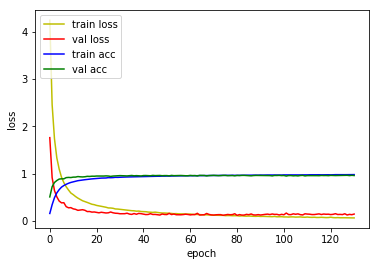

4815/4815 [==============================] - 2s 499us/sample - loss: 0.1621 - acc: 0.9520
Loss: 0.16212015172093333 Accuracy: 0.95202494

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6468 - acc: 0.1926
Epoch 00001: val_loss improved from inf to 1.69077, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_8_conv_checkpoint/001-1.6908.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 3.6465 - acc: 0.1926 - val_loss: 1.6908 - val_acc: 0.4773
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9470 - acc: 0.4332
Epoch 00002: val_loss improved from 1.69077 to 0.82366, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_8_conv_checkpoint/002-0.8237.hdf5
36805/36805 [==============================] - 34s 914us/sample - loss: 1.9469 - acc: 0.4332 - val_loss: 0.8237 - val_acc: 0.7587
Epoch 3/500
36800/36805 [====================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2028 - acc: 0.9360
Epoch 00023: val_loss improved from 0.14277 to 0.13405, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_8_conv_checkpoint/023-0.1340.hdf5
36805/36805 [==============================] - 34s 911us/sample - loss: 0.2028 - acc: 0.9360 - val_loss: 0.1340 - val_acc: 0.9595
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1942 - acc: 0.9387
Epoch 00024: val_loss did not improve from 0.13405
36805/36805 [==============================] - 34s 912us/sample - loss: 0.1941 - acc: 0.9387 - val_loss: 0.1409 - val_acc: 0.9546
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1872 - acc: 0.9422
Epoch 00025: val_loss did not improve from 0.13405
36805/36805 [==============================] - 33s 909us/sample - loss: 0.1872 - acc: 0.9422 - val_loss: 0.1620 - val_acc: 0.9457
Epoch 26/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0899 - acc: 0.9714
Epoch 00051: val_loss did not improve from 0.12222
36805/36805 [==============================] - 33s 909us/sample - loss: 0.0899 - acc: 0.9714 - val_loss: 0.1310 - val_acc: 0.9627
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0870 - acc: 0.9736
Epoch 00052: val_loss did not improve from 0.12222
36805/36805 [==============================] - 34s 911us/sample - loss: 0.0870 - acc: 0.9736 - val_loss: 0.1332 - val_acc: 0.9599
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0826 - acc: 0.9732
Epoch 00053: val_loss did not improve from 0.12222
36805/36805 [==============================] - 33s 907us/sample - loss: 0.0826 - acc: 0.9732 - val_loss: 0.1275 - val_acc: 0.9609
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0833 - acc: 0.9736
Epoch 00054: val_loss did not improve from 0.12222
36805/36805 [==================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0525 - acc: 0.9838
Epoch 00080: val_loss did not improve from 0.11772
36805/36805 [==============================] - 34s 915us/sample - loss: 0.0525 - acc: 0.9838 - val_loss: 0.1208 - val_acc: 0.9655
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9858
Epoch 00081: val_loss did not improve from 0.11772
36805/36805 [==============================] - 33s 908us/sample - loss: 0.0459 - acc: 0.9858 - val_loss: 0.1327 - val_acc: 0.9627
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9859
Epoch 00082: val_loss did not improve from 0.11772
36805/36805 [==============================] - 33s 907us/sample - loss: 0.0470 - acc: 0.9859 - val_loss: 0.1349 - val_acc: 0.9616
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9863
Epoch 00083: val_loss did not improve from 0.11772
36805/36805 [=====


1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_8_conv Model


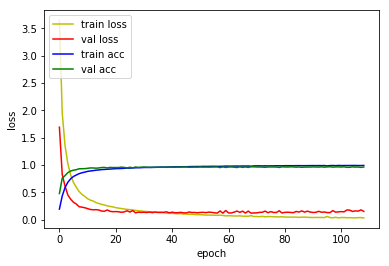

4815/4815 [==============================] - 3s 533us/sample - loss: 0.1739 - acc: 0.9499
Loss: 0.17385099906230642 Accuracy: 0.9499481



In [10]:
base = '1D_CNN_custom_multi_3_GMP_ch_32_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_GMP_ch_32_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_33[0][0]  
_________________________________________________________

4815/4815 [==============================] - 3s 554us/sample - loss: 0.5595 - acc: 0.8345
Loss: 0.5594838753667576 Accuracy: 0.8344756

1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activa

4815/4815 [==============================] - 3s 600us/sample - loss: 0.1908 - acc: 0.9396
Loss: 0.1907717812779289 Accuracy: 0.9395639

1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activa

4815/4815 [==============================] - 3s 648us/sample - loss: 0.1739 - acc: 0.9499
Loss: 0.17385099906230642 Accuracy: 0.9499481


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_33[0][0]  
_________________________________________________________

4815/4815 [==============================] - 3s 626us/sample - loss: 0.5606 - acc: 0.8272
Loss: 0.5606159564428735 Accuracy: 0.8272067

1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activa

4815/4815 [==============================] - 3s 684us/sample - loss: 0.2029 - acc: 0.9423
Loss: 0.20292908532597195 Accuracy: 0.9422638

1D_CNN_custom_multi_3_GMP_ch_32_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activ

4815/4815 [==============================] - 4s 751us/sample - loss: 0.2146 - acc: 0.9477
Loss: 0.21461567844139454 Accuracy: 0.94766355
